In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from os import fdopen, remove, walk
import glob
from tempfile import mkstemp
import shutil
from shutil import move, copymode

In [3]:
from datetime import date

In [4]:
DATASET_PATH = "/Users/noopy/covid19_unknown_spread/dataset"

In [5]:
# get oldest file in the dataset folder
import os, heapq
def newst_files_in_tree(rootfolder, count=1, extension=".csv"):
    return heapq.nlargest(count,
        (os.path.join(dirname, filename)
        for dirname, dirnames, filenames in os.walk(rootfolder)
        for filename in filenames
        if filename.endswith(extension)),
        key=lambda fn: os.stat(fn).st_mtime)

In [6]:
newst_csv = newst_files_in_tree(DATASET_PATH)[0]

In [7]:
df_temp = pd.read_csv(newst_csv, encoding="utf-8")
df_temp.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
3368,1489,13802,7.20.,강서구,-,강서구 요양시설 관련,퇴원
927,3930,20114,8.31.,종로구,-,타시도 확진자 접촉,NaN
2854,2003,15432,8.16.,강서구,-,양천구 되새김교회 관련,퇴원
1798,3059,17704,8.24.,노원구,-,노원구 빛가온교회 관련,퇴원
2427,2430,16248,8.19.,강북구,-,성북구 체대입시 관련,퇴원
1277,3580,19274,8.28.,영등포구,-,기타 확진자 접촉,퇴원
4050,807,11306,5.27.,성동구,-,이태원 클럽 관련,퇴원
2245,2612,16580,8.20.,동대문구,-,기타 확진자 접촉,퇴원
1782,3075,17844,8.24.,타시도,-,기타 확진자 접촉,퇴원
3782,1075,12006,6.12.,성북구,-,확인 중,퇴원


In [8]:
# overwrite whatever cell value that contains "확인" as "확인 중"
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"] = "확인 중"

# check whether those two arrays are combined
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"].unique()

array(['확인 중'], dtype=object)

In [9]:
df_temp["접촉력"] = df_temp["접촉력"].str.replace("관련", "")
df_temp["접촉력"] = df_temp["접촉력"].str.strip()

In [10]:
infection_paths = df_temp["접촉력"].unique()
print(len(infection_paths))
infection_paths

232


array(['확인 중', '강남구 K보건산업', '해외 접촉 추정', '서대문구 소재 세브란스병원', '기타 확진자 접촉',
       '타시도 확진자 접촉', '서대문구 세브란스병원', '서대문구 소재 세브란스 병원', '성남 서호주간센터',
       '서대문구 세브란스 병원', '서대문구 지인모임', '영등포 지인모임', '송파구 우리교회', '송파구 교회',
       '관악구 판매업소', '광진구 혜민병원', '8.15서울도심집회', '도봉구 건설현장', '도봉구 운동시설',
       '송파구 쿠팡', '종로구청', '노원구 빛가온교회', '동작구 요양시설', '서초구 장애인교육시설',
       '강동구 BF모바일', '영등포구 일련정종 서울포교소', '동작구 진흥글로벌', '구로구 아파트', 'KT가좌지사',
       '성북구 사랑제일교회', '노원구 기도모임', '관악구 가족모임', '영등포구 국회출입기자', '은평구 수색성당',
       '은평구 헤어콕', '송파구 소재병원', '극단 산', '영등포구 권능교회', '강동구 소재 병원', '다래경매',
       '성북구 체대입시', '성북구 요양시설', '중구소재 은행', '중랑구 소재 체육시설', '동작구 소재 서울신학교',
       '용인시 우리제일교회', '노원구 손해보험', '구로구 보성운수', '강서구 서울대효요양병원', '강북구 일가족',
       '강서구 보안회사', '롯데리아 종사자 모임', '강남구 소재 아파트', '제주 게스트하우스', '성북구 벧엘장로교회',
       '관악구 김혜근의원', '동대문구 sk탁구클럽', '동작구 스터디카페', '군인권센터', '여의도 순복음교회',
       '중구 보험회사(현대해상)', '강서구 병원', '종로구 혜화경찰서', '양천구 되새김교회', '현대커머셜',
       '영등포 IFC몰 오케스트로', '고양시 반석교회(케네디상가)', '롯데 자산개발', '골드트레인', '한양대병원',
       '

In [11]:
df_date = df_temp.sort_values(["연번"], ascending=False)
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4857,22650,9.16.,기타,-,확인 중,NaN
1,4856,22648,9.16.,기타,-,확인 중,NaN
2,4855,22654,9.16.,타시도,-,강남구 K보건산업,NaN
3,4854,22649,9.16.,관악구,-,확인 중,NaN
4,4853,22653,9.16.,강동구,-,해외 접촉 추정,NaN


In [12]:
df_date["확진일"] = df_date["확진일"].str.replace(".", "-")
df_date["확진일"] = df_date["확진일"].str[:-1]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4857,22650,9-16,기타,-,확인 중,NaN
1,4856,22648,9-16,기타,-,확인 중,NaN
2,4855,22654,9-16,타시도,-,강남구 K보건산업,NaN
3,4854,22649,9-16,관악구,-,확인 중,NaN
4,4853,22653,9-16,강동구,-,해외 접촉 추정,NaN


In [13]:
df_date["확진일"] = "2020-0" + df_date["확진일"]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4857,22650,2020-09-16,기타,-,확인 중,NaN
1,4856,22648,2020-09-16,기타,-,확인 중,NaN
2,4855,22654,2020-09-16,타시도,-,강남구 K보건산업,NaN
3,4854,22649,2020-09-16,관악구,-,확인 중,NaN
4,4853,22653,2020-09-16,강동구,-,해외 접촉 추정,NaN


In [14]:
df_date.sample(5)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
764,4093,20319,2020-08-31,노원구,-,기타 확진자 접촉,퇴원
513,4344,21201,2020-09-06,도봉구,-,기타 확진자 접촉,NaN
4265,592,10396,2020-04-09,성동구,미국,해외 접촉 추정,퇴원
1793,3064,17855,2020-08-24,관악구,-,확인 중,NaN
1276,3581,19340,2020-08-28,영등포구,-,기타 확진자 접촉,퇴원


In [15]:
df = df_date.copy()
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4857,22650,2020-09-16,기타,-,확인 중,NaN
1,4856,22648,2020-09-16,기타,-,확인 중,NaN
2,4855,22654,2020-09-16,타시도,-,강남구 K보건산업,NaN
3,4854,22649,2020-09-16,관악구,-,확인 중,NaN
4,4853,22653,2020-09-16,강동구,-,해외 접촉 추정,NaN


In [16]:
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-0", "-")
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-", "-0")
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4857,22650,2020-09-16,기타,-,확인 중,NaN
1,4856,22648,2020-09-16,기타,-,확인 중,NaN
2,4855,22654,2020-09-16,타시도,-,강남구 K보건산업,NaN
3,4854,22649,2020-09-16,관악구,-,확인 중,NaN
4,4853,22653,2020-09-16,강동구,-,해외 접촉 추정,NaN


In [17]:
df.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
1407,3450,18992,2020-08-27,송파구,-,성북구 사랑제일교회,퇴원
3629,1228,12482,2020-06-22,강서구,-,리치웨이,퇴원
4461,396,9543,2020-03-28,관악구,미국,해외 접촉 추정,퇴원
723,4134,20659,2020-09-02,용산구,-,확인 중,NaN
2548,2309,15939,2020-08-18,성북구,-,성북구 사랑제일교회,퇴원
2150,2707,16796,2020-08-21,양천구,-,확인 중,퇴원
514,4343,21234,2020-09-06,관악구,-,확인 중,NaN
4047,810,11296,2020-05-27,성동구,-,이태원 클럽,퇴원
1458,3399,18768,2020-08-27,강서구,-,기타 확진자 접촉,퇴원
2215,2642,16733,2020-08-21,강남구,-,기타 확진자 접촉,퇴원


In [18]:
df.to_csv("./dataset_predict/df_wrangle.csv", index=False)

In [19]:
temp = df["확진일"].value_counts().rename_axis('date').reset_index(name='new_confirmed')
temp.head()

,date,new_confirmed
0,2020-08-29,167
1,2020-08-27,160
2,2020-08-26,157
3,2020-08-18,151
4,2020-08-15,146


In [20]:
df_predict = temp.sort_values(by="date")
df_predict.head()

,date,new_confirmed
204,2020-01-24,1
178,2020-01-30,3
176,2020-01-31,3
199,2020-02-02,1
187,2020-02-05,2


### stretch the dataframe as timeseries dataset with interval of 1 day 

In [21]:
df_predict["date"] = pd.to_datetime(df_predict["date"])

In [22]:
df_predict.index = pd.DatetimeIndex(df_predict["date"])
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1
2020-01-30,2020-01-30,3
2020-01-31,2020-01-31,3
2020-02-02,2020-02-02,1
2020-02-05,2020-02-05,2


In [23]:
df_predict = df_predict.resample('D').max()
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,NaT,NaN
2020-01-26,NaT,NaN
2020-01-27,NaT,NaN
2020-01-28,NaT,NaN


In [24]:
df_predict["date"] = df_predict.index
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,NaN
2020-01-26,2020-01-26,NaN
2020-01-27,2020-01-27,NaN
2020-01-28,2020-01-28,NaN


In [25]:
df_predict = df_predict.fillna(0)
df_predict[:10]

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,0.0
2020-01-26,2020-01-26,0.0
2020-01-27,2020-01-27,0.0
2020-01-28,2020-01-28,0.0
2020-01-29,2020-01-29,0.0
2020-01-30,2020-01-30,3.0
2020-01-31,2020-01-31,3.0
2020-02-01,2020-02-01,0.0


In [26]:
df_predict.to_csv("dataset_predict/df_predict.csv", index=False)

In [27]:
df_predict =  pd.read_csv("dataset_predict/df_predict.csv", encoding="utf-8")

### get untracked patients information

In [28]:
df_untracked = df[df["접촉력"]=="확인 중"]
df_untracked

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4857,22650,2020-09-16,기타,-,확인 중,NaN
1,4856,22648,2020-09-16,기타,-,확인 중,NaN
3,4854,22649,2020-09-16,관악구,-,확인 중,NaN
6,4851,22625,2020-09-16,관악구,-,확인 중,NaN
7,4850,22634,2020-09-16,동작구,-,확인 중,NaN
...,...,...,...,...,...,...,...
4801,56,1768,2020-02-25,고양시,-,확인 중,퇴원
4815,42,1370,2020-02-25,노원구,-,확인 중,퇴원
4818,39,924,2020-02-25,평택,-,확인 중,퇴원
4819,38,907,2020-02-25,관악구,-,확인 중,퇴원


In [29]:
df_untracked_temp = df_untracked.groupby(by=["확진일"]).size()
df_untracked_temp = df_untracked_temp.rename_axis('date').reset_index(name='new_untracked')
df_untracked_temp

,date,new_untracked
0,2020-02-25,6
1,2020-02-26,1
2,2020-02-27,2
3,2020-02-28,2
4,2020-03-02,2
...,...,...
131,2020-09-12,13
132,2020-09-13,8
133,2020-09-14,10
134,2020-09-15,14


In [30]:
df_untracked_no = df_untracked_temp

In [31]:
df_merged = pd.merge(df_predict, df_untracked_no, how="left", on="date")
df_merged = df_merged.fillna(0)
df_merged.head(15)

,date,new_confirmed,new_untracked
0,2020-01-24,1.0,0.0
1,2020-01-25,0.0,0.0
2,2020-01-26,0.0,0.0
3,2020-01-27,0.0,0.0
4,2020-01-28,0.0,0.0
5,2020-01-29,0.0,0.0
6,2020-01-30,3.0,0.0
7,2020-01-31,3.0,0.0
8,2020-02-01,0.0,0.0
9,2020-02-02,1.0,0.0


In [32]:
df_merged.tail(15)

,date,new_confirmed,new_untracked
222,2020-09-02,64.0,12.0
223,2020-09-03,46.0,6.0
224,2020-09-04,55.0,6.0
225,2020-09-05,58.0,19.0
226,2020-09-06,44.0,13.0
227,2020-09-07,76.0,19.0
228,2020-09-08,30.0,10.0
229,2020-09-09,47.0,9.0
230,2020-09-10,64.0,9.0
231,2020-09-11,49.0,13.0


In [33]:
list_infection_paths_no = []
for index, row in df_merged.iterrows():
    filter_end_date = row["date"]
    # print(filter_end_date)
    df_filtered = df.loc[df['확진일'] <= filter_end_date]
    
    # 확진자 접촉력이 밝혀진 경우
    infection_paths_known_no = len(df_filtered["접촉력"].unique())
    
    # "기타 확진자 접촉", "타시도 확진자 접촉" 항목 485건 / R0
    etc_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("기타 확진자 접촉")])/1.5
    state_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("타시도 확진자 접촉")])/1.5

    infection_paths_no = infection_paths_known_no + etc_contact_no + state_contact_no
    list_infection_paths_no.append(int(infection_paths_no))
print(list_infection_paths_no[:10])
print(list_infection_paths_no[-10:])

[1, 1, 1, 1, 1, 1, 2, 4, 4, 4]
[692, 703, 714, 726, 737, 749, 764, 774, 788, 806]


In [34]:
df_merged["no_paths"] = list_infection_paths_no
df_merged["new_confirmed"] = df_merged["new_confirmed"].apply(int)
df_merged["new_untracked"] = df_merged["new_untracked"].apply(int)
df_merged.head()

,date,new_confirmed,new_untracked,no_paths
0,2020-01-24,1,0,1
1,2020-01-25,0,0,1
2,2020-01-26,0,0,1
3,2020-01-27,0,0,1
4,2020-01-28,0,0,1


In [35]:
df_merged.tail()

,date,new_confirmed,new_untracked,no_paths
232,2020-09-12,34,13,749
233,2020-09-13,41,8,764
234,2020-09-14,36,10,774
235,2020-09-15,49,14,788
236,2020-09-16,58,24,806


In [36]:
df_merged["new_no_paths"] = df_merged["no_paths"].diff()
df_merged.tail()

,date,new_confirmed,new_untracked,no_paths,new_no_paths
232,2020-09-12,34,13,749,12.0
233,2020-09-13,41,8,764,15.0
234,2020-09-14,36,10,774,10.0
235,2020-09-15,49,14,788,14.0
236,2020-09-16,58,24,806,18.0


In [37]:
df_merged = df_merged[["date", "new_confirmed", "new_untracked", "new_no_paths"]]

In [38]:
df_merged.to_csv("dataset_predict/df_predict.csv", index=False)

### Label holiday as column

In [39]:
import json

list_calendar=[]

calendar_file = "./korean-calendar/korean-calendar.json"
# read file
with open(calendar_file, 'r') as myfile:
    data=myfile.readlines()

data = [x.strip() for x in data] 

for i in data:
    calendar_data = i[43:]
    calendar_item = "{"+calendar_data
    calendar_item_json = json.loads(calendar_item)
    list_calendar.append(calendar_item_json)
list_calendar[:10]

[{'sc': '2000-01-01', 'lc': '1999-11-25', 'w': 7, 'h': True, 'ht': '신정'},
 {'sc': '2000-01-02', 'lc': '1999-11-26', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-03', 'lc': '1999-11-27', 'w': 2, 'h': False, 'ht': ''},
 {'sc': '2000-01-04', 'lc': '1999-11-28', 'w': 3, 'h': False, 'ht': ''},
 {'sc': '2000-01-05', 'lc': '1999-11-29', 'w': 4, 'h': False, 'ht': ''},
 {'sc': '2000-01-06', 'lc': '1999-11-30', 'w': 5, 'h': False, 'ht': ''},
 {'sc': '2000-01-07', 'lc': '1999-12-01', 'w': 6, 'h': False, 'ht': ''},
 {'sc': '2000-01-08', 'lc': '1999-12-02', 'w': 7, 'h': False, 'ht': ''},
 {'sc': '2000-01-09', 'lc': '1999-12-03', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-10', 'lc': '1999-12-04', 'w': 2, 'h': False, 'ht': ''}]

In [40]:
df_calendar = pd.DataFrame(list_calendar)
df_calendar = df_calendar[["sc", "w", "h"]]
df_calendar.head()

,sc,w,h
0,2000-01-01,7,True
1,2000-01-02,1,False
2,2000-01-03,2,False
3,2000-01-04,3,False
4,2000-01-05,4,False


In [41]:
# notate sunday, friday, saturday as weekend: which is 1
def label_weekend(row):
    # sunday
    if row['w'] == 1:
        return 1
    # friday
    if row['w'] == 6:
        return 1
    # saturday
    if row['w'] == 7:
        return 1
    else:
        return 0

In [42]:
df_calendar["is_weekend"] = df_calendar.apply(lambda row: label_weekend(row), axis=1)
df_calendar.head(10)

,sc,w,h,is_weekend
0,2000-01-01,7,True,1
1,2000-01-02,1,False,1
2,2000-01-03,2,False,0
3,2000-01-04,3,False,0
4,2000-01-05,4,False,0
5,2000-01-06,5,False,0
6,2000-01-07,6,False,1
7,2000-01-08,7,False,1
8,2000-01-09,1,False,1
9,2000-01-10,2,False,0


In [43]:
# rename dataframe name
df_calendar.rename(columns = {'sc':'date', 'h':'is_holiday'}, inplace = True)

In [44]:
# if it is holiday, notate as 1. If not, notate as 0
df_calendar.loc[df_calendar["is_holiday"]==True, "is_holiday"] = 1
df_calendar.loc[df_calendar["is_holiday"]==False, "is_holiday"] = 0
df_calendar[:10]

,date,w,is_holiday,is_weekend
0,2000-01-01,7,1,1
1,2000-01-02,1,0,1
2,2000-01-03,2,0,0
3,2000-01-04,3,0,0
4,2000-01-05,4,0,0
5,2000-01-06,5,0,0
6,2000-01-07,6,0,1
7,2000-01-08,7,0,1
8,2000-01-09,1,0,1
9,2000-01-10,2,0,0


In [45]:
df_calendar.to_csv("dataset_predict/df_calendar.csv", index=False)

In [46]:
df_calendar_subset = df_calendar[["date", "is_holiday", "is_weekend"]]

In [47]:
df_train = pd.merge(df_merged, df_calendar_subset, how="left", on="date")
df_train.tail()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend
232,2020-09-12,34,13,12.0,0,1
233,2020-09-13,41,8,15.0,0,1
234,2020-09-14,36,10,10.0,0,0
235,2020-09-15,49,14,14.0,0,0
236,2020-09-16,58,24,18.0,0,0


### Add Government Social Distancing Policy

In [48]:
df_train["gov_policy"] = 0
df_train[-10:]

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
227,2020-09-07,76,19,18.0,0,0,0
228,2020-09-08,30,10,11.0,0,0,0
229,2020-09-09,47,9,11.0,0,0,0
230,2020-09-10,64,9,12.0,0,0,0
231,2020-09-11,49,13,11.0,0,1,0
232,2020-09-12,34,13,12.0,0,1,0
233,2020-09-13,41,8,15.0,0,1,0
234,2020-09-14,36,10,10.0,0,0,0
235,2020-09-15,49,14,14.0,0,0,0
236,2020-09-16,58,24,18.0,0,0,0


In [49]:
# 서울의 사회적 거리두기 2단계는 8월 16일부터 조치됨
# 서울에는 8월 19일 0시 기준으로 새로운 조치들이 추가되며, 흔히 얘기하는 2.5단계가 됨. 이후에 기간 연장을 해서 9.7(월)0시 ~ 9.13(일)24시까지 2.5단계가 시행됨

df_train.loc[(df_train["date"]>="2020-08-16") & (df_train["date"]<="2020-08-18"),"gov_policy"] = 2
df_train.loc[(df_train["date"]>="2020-08-19") & (df_train["date"]<="2020-09-13"),"gov_policy"] = 3


In [50]:
df_train.to_csv("./dataset_predict/df_train.csv", index=False)

## EDA

In [51]:
df_train.corr()

,new_confirmed,new_untracked,new_no_paths,is_weekend,gov_policy
new_confirmed,1.000000,0.874179,0.872548,-0.021510,0.794979
new_untracked,0.874179,1.000000,0.923753,-0.042397,0.807181
new_no_paths,0.872548,0.923753,1.000000,0.008107,0.855822
is_weekend,-0.021510,-0.042397,0.008107,1.000000,0.016488
gov_policy,0.794979,0.807181,0.855822,0.016488,1.000000


<AxesSubplot:>

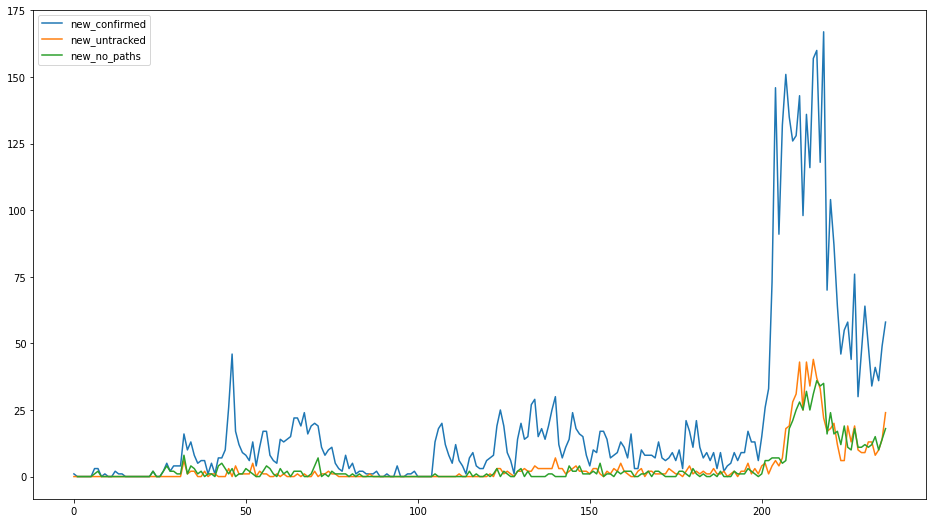

In [52]:
# 전체 그래프
df_train[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

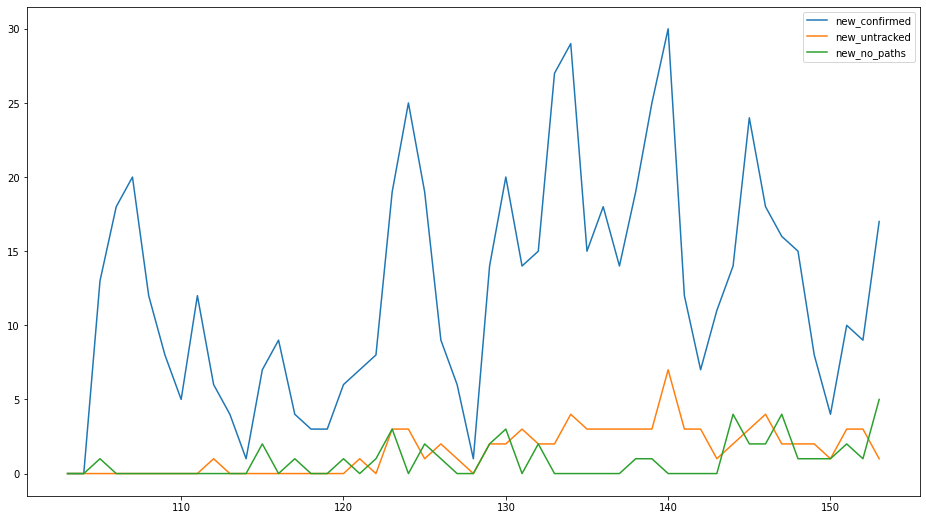

In [53]:
itaewon_crisis = df_train[(df_train["date"]>="2020-05-06") & (df_train["date"]<="2020-06-25")]
itaewon_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))


<AxesSubplot:>

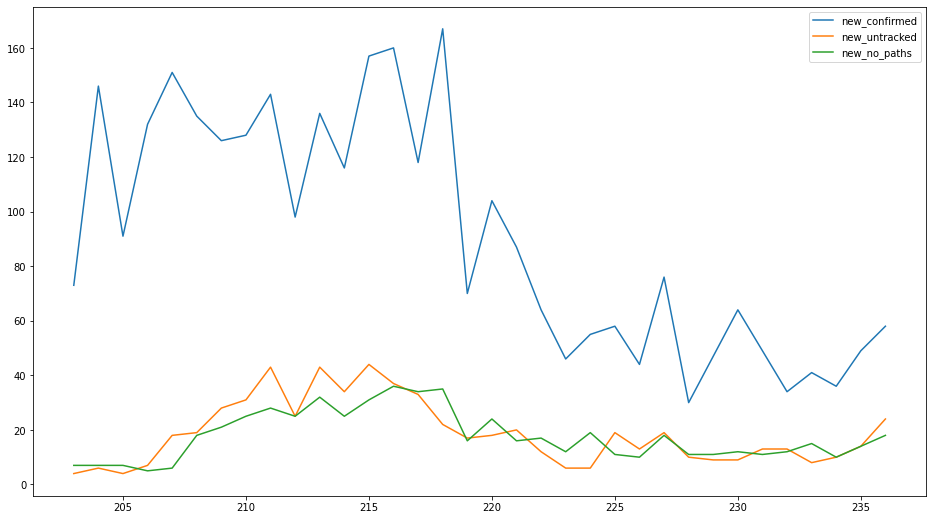

In [54]:
# 서울시 사랑제일교회 광복절 집회 이후의 데이터
jkh_crisis = df_train[(df_train["date"]>="2020-08-14")]
jkh_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

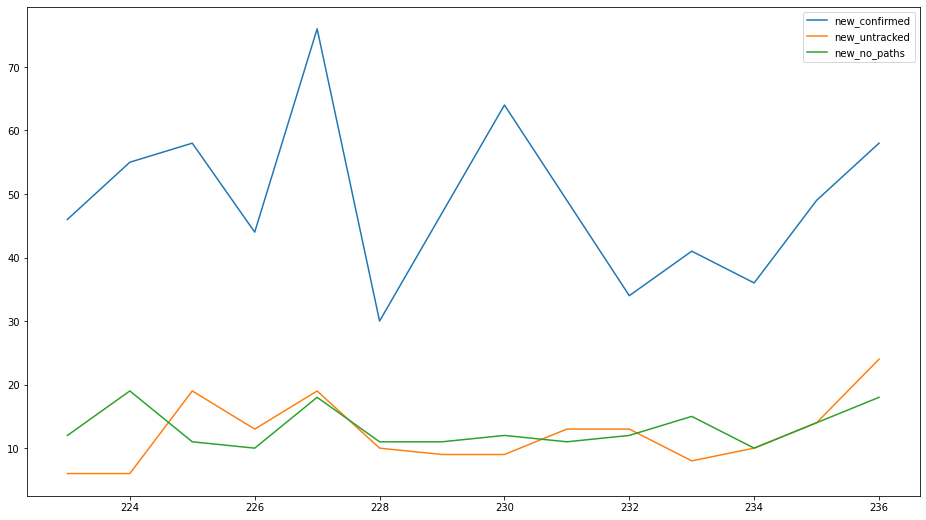

In [55]:
# 최근 2주 데이터
recent_two_weeks_data = df_train.tail(14)
recent_two_weeks_data[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

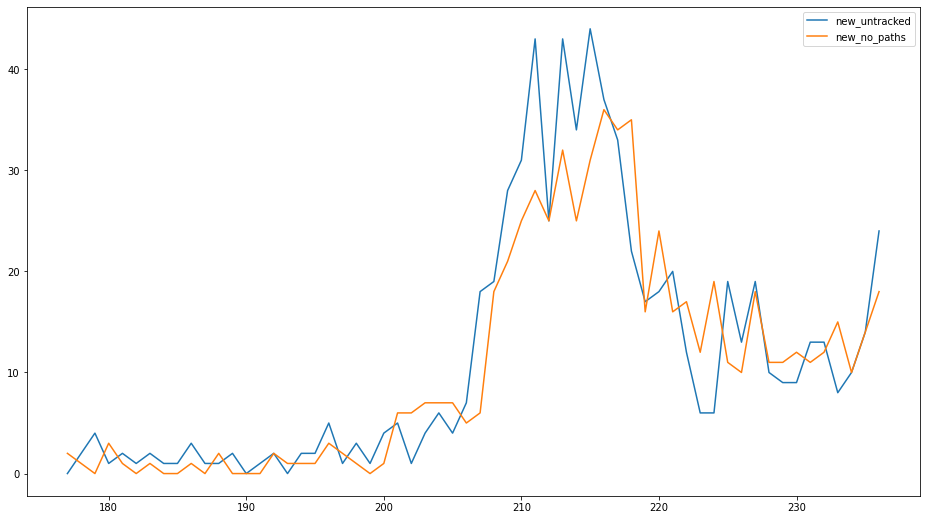

In [56]:
# 확인된 감염경로 개수와 경로 미확인 감염자 트렌드
df_train[["new_untracked", "new_no_paths"]][-60:].plot(figsize=(16,9))